In [23]:
import h5py
from pathlib import Path
import warnings
import numba
from tensorflow.keras.preprocessing.sequence import pad_sequences
from helper_functions import *
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import joblib
from scipy.stats import ttest_ind
from sktime.classification.kernel_based import RocketClassifier
from sktime.classification.dummy import DummyClassifier

warnings.filterwarnings('ignore')

In [19]:
LEARNER_ZOO = {0: 'SVC_linear', 1: 'SVC_poly', 2: 'SVC_rbf', 3: 'SVC_sigmoid', 4: 'Decision Trees', 5: 'ExtraTrees', 6: 'LogisticRegression', 7: 'PassiveAggressive', 8: 'Perceptron', 9: 'RidgeClassifier', 10: 'SGDClassifier', 11: 'MLP', 12: 'LDA', 13: 'QDA', 14: 'BernoulliNB', 15: 'MultinomialNB', 16: 'ComplementNB', 17: 'GaussianNB', 18: 'KNN', 19: 'NearestCentroid', 20: 'ens.ExtraTrees', 21: 'ens.RandomForest', 22: 'ens.GradientBoosting', 23: 'DummyClassifier'}

In [20]:
data_path = Path.cwd() / 'dataset/LCDB11_ACC_265_noFS_raw_compress.hdf5'
with h5py.File(data_path, 'r') as f:
    train_raw = np.nanmean(f['accuracy'][...][:,:,:,:,:,0], axis=(2, 3))
    valid_raw = np.nanmean(f['accuracy'][...][:,:,:,:,:,1], axis=(2, 3))
    test_raw  = np.nanmean(f['accuracy'][...][:,:,:,:,:,2], axis=(2, 3))

# flatten
train_curves = train_raw.reshape(-1, train_raw.shape[-1])
valid_curves = valid_raw.reshape(-1, valid_raw.shape[-1])
test_curves  = test_raw.reshape(-1,  test_raw.shape[-1])

# labels
labels = np.tile(np.arange(24), 265)

train_curves.shape, valid_curves.shape, test_curves.shape, labels.shape

((6360, 137), (6360, 137), (6360, 137), (6360,))

In [21]:
group_definitions = {
    0: ['Perceptron', 'PassiveAggressive', 'SGDClassifier', 'SVC_linear'],
    1: ['Decision Tree', 'ExtraTree', 'MLP'],
    2: ['SVC_poly', 'SVC_rbf', 'ens.ExtraTrees', 'ens.RandomForest', 'KNN'],
    3: ['MultinomialNB', 'ComplementNB', 'NearestCentroid', 'GaussianNB', 'BernoulliNB'],
    4: ['RidgeClassifier', 'LogisticRegression', 'LDA'],
    5: ['DummyClassifier', 'SVC_sigmoid', 'QDA', 'ens.GradientBoosting'],
}

filtered_train_curves, filtered_valid_curves, filtered_test_curves, learner_ids, group_ids = filter_by_group_definitions_together(
    train_curves, valid_curves, test_curves, labels, group_definitions, LEARNER_ZOO
)

len(filtered_train_curves), len(filtered_valid_curves), len(filtered_test_curves), learner_ids.shape, group_ids.shape

(5830, 5830, 5830, (5830,), (5830,))

In [22]:
cleaned_train, cleaned_valid, cleaned_test, cleaned_labels = clean_curves_together(
    filtered_train_curves, filtered_valid_curves, 
    filtered_test_curves, group_ids, 
    min_length=50,
)


# find max length among all three splits
MAX_LEN = max(
    max((len(seq) for seq in cleaned_train), default=0),
    max((len(seq) for seq in cleaned_valid), default=0),
    max((len(seq) for seq in cleaned_test),  default=0)
)

# pad each split separately
padded_train = pad_sequences(cleaned_train, maxlen=MAX_LEN, dtype='float32', padding='post', truncating='post')
padded_valid = pad_sequences(cleaned_valid, maxlen=MAX_LEN, dtype='float32', padding='post', truncating='post')
padded_test  = pad_sequences(cleaned_test,  maxlen=MAX_LEN, dtype='float32', padding='post', truncating='post')


# concatenate all padded curves and labels
all_combined = np.concatenate([padded_train, padded_valid, padded_test], axis=1)
train_valid = np.concatenate([padded_train, padded_valid], axis=1)
train_test = np.concatenate([padded_train, padded_test], axis=1)
valid_test = np.concatenate([padded_valid, padded_test], axis=1)

all_combined.shape, train_valid.shape, train_test.shape, valid_test.shape, padded_valid.shape, padded_test.shape, padded_train.shape, cleaned_labels.shape

((3853, 399),
 (3853, 266),
 (3853, 266),
 (3853, 266),
 (3853, 133),
 (3853, 133),
 (3853, 133),
 (3853,))

In [26]:
clf = DummyClassifier(random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(clf, all_combined, cleaned_labels, cv=cv)

joblib.dump(clf, f'trained_models/experiment-combined-curves/dummy/dummy_clf.joblib')
joblib.dump(scores, f'scores/experiment-combined-curves/dummy/dummy_scores.joblib')

['scores/experiment-combined-curves//dummy_scores.joblib']

In [9]:
clf = RocketClassifier(rocket_transform='minirocket', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(clf, all_combined, cleaned_labels, cv=cv)

joblib.dump(clf, f'trained_models/experiment-combined-curves/minirocket/minirocket_all_combined_clf.joblib')
joblib.dump(scores, f'scores/experiment-combined-curves/minirocket/minirocket_all_combined_scores.joblib')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


['scores/experiment-combined-curves/minirocket/minirocket_all_combined_scores.joblib']

In [10]:
clf = RocketClassifier(rocket_transform='minirocket', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(clf, train_valid, cleaned_labels, cv=cv)

joblib.dump(clf, f'trained_models/experiment-combined-curves/minirocket/minirocket_train_valid_clf.joblib')
joblib.dump(scores, f'scores/experiment-combined-curves/minirocket/minirocket_train_valid_scores.joblib')

['scores/experiment-combined-curves/minirocket/minirocket_train_valid_scores.joblib']

In [11]:
clf = RocketClassifier(rocket_transform='minirocket', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(clf, train_test, cleaned_labels, cv=cv)

joblib.dump(clf, f'trained_models/experiment-combined-curves/minirocket/minirocket_train_test_clf.joblib')
joblib.dump(scores, f'scores/experiment-combined-curves/minirocket/minirocket_train_test_scores.joblib')

['scores/experiment-combined-curves/minirocket/minirocket_train_test_scores.joblib']

In [12]:
clf = RocketClassifier(rocket_transform='minirocket', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(clf, valid_test, cleaned_labels, cv=cv)

joblib.dump(clf, f'trained_models/experiment-combined-curves/minirocket/minirocket_valid_test_clf.joblib')
joblib.dump(scores, f'scores/experiment-combined-curves/minirocket/minirocket_valid_test_scores.joblib')

['scores/experiment-combined-curves/minirocket/minirocket_valid_test_scores.joblib']

In [13]:
clf = RocketClassifier(rocket_transform='minirocket', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(clf, padded_train, cleaned_labels, cv=cv)

joblib.dump(clf, f'trained_models/experiment-combined-curves/minirocket/minirocket_only_train_clf.joblib')
joblib.dump(scores, f'scores/experiment-combined-curves/minirocket/minirocket_only_train_scores.joblib')

['scores/experiment-combined-curves/minirocket/minirocket_only_train_scores.joblib']

In [14]:
clf = RocketClassifier(rocket_transform='minirocket', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(clf, padded_valid, cleaned_labels, cv=cv)

joblib.dump(clf, f'trained_models/experiment-combined-curves/minirocket/minirocket_only_valid_clf.joblib')
joblib.dump(scores, f'scores/experiment-combined-curves/minirocket/minirocket_only_valid_scores.joblib')

['scores/experiment-combined-curves/minirocket/minirocket_only_valid_scores.joblib']

In [15]:
clf = RocketClassifier(rocket_transform='minirocket', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(clf, padded_test, cleaned_labels, cv=cv)

joblib.dump(clf, f'trained_models/experiment-combined-curves/minirocket/minirocket_only_test_clf.joblib')
joblib.dump(scores, f'scores/experiment-combined-curves/minirocket/minirocket_only_test_scores.joblib')

['scores/experiment-combined-curves/minirocket/minirocket_only_test_scores.joblib']

In [16]:
clf = RocketClassifier(rocket_transform='minirocket', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(clf, all_combined, cleaned_labels, cv=cv)

joblib.dump(clf, f'trained_models/experiment-combined-curves/minirocket/minirocket_all_combined_clf.joblib')
joblib.dump(scores, f'scores/experiment-combined-curves/minirocket/minirocket_all_combined_scores.joblib')

['scores/experiment-combined-curves/minirocket/minirocket_all_combined_scores.joblib']

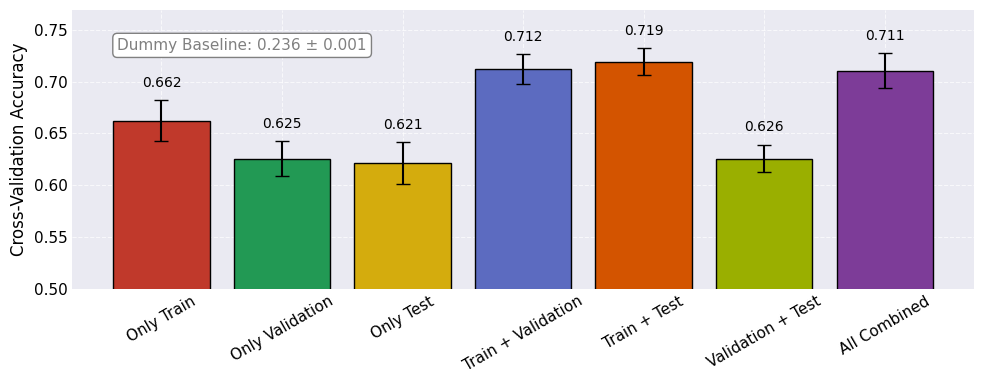

In [29]:
experiment_suffixes = [
    "only_train",
    "only_valid",
    "only_test",
    "train_valid",
    "train_test",
    "valid_test",
    "all_combined"
]

label_map = {
    "only_train": "Only Train",
    "only_valid": "Only Validation",
    "only_test": "Only Test",
    "train_valid": "Train + Validation",
    "train_test": "Train + Test",
    "valid_test": "Validation + Test",
    "all_combined": "All Combined"
}

# color map
color_map = {
    "only_train": "#c0392b",      
    "only_valid": "#229954",      
    "only_test":  "#d4ac0d",      
    "train_valid": "#5c6bc0",     
    "train_test":  "#d35400",  
    "valid_test":  "#9aaf00",    
    "all_combined": "#7d3c98"   
}

score_dir = "scores/experiment-combined-curves/minirocket"
scores_dict = {}

for suffix in experiment_suffixes:
    score_path = f"{score_dir}/minirocket_{suffix}_scores.joblib"
    scores = joblib.load(score_path)
    scores_dict[suffix] = scores

labels = [label_map[k] for k in experiment_suffixes]
means = [scores_dict[k].mean() for k in experiment_suffixes]
stds = [scores_dict[k].std() for k in experiment_suffixes]
colors = [color_map[k] for k in experiment_suffixes]

dummy_scores = joblib.load("scores/experiment-combined-curves/dummy/dummy_scores.joblib")

plt.rcParams.update({
    'font.size': 12,       
    'axes.titlesize': 12,  
    'axes.labelsize': 12,  
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 12
})

plt.figure(figsize=(10, 4))

ax = plt.gca()
ax.set_facecolor('#EAEAF2')
ax.set_axisbelow(True)
ax.grid(True, linestyle='--', alpha=0.7, color='white')
ax.tick_params(axis='both', length=0)

for spine in ax.spines.values():
    spine.set_visible(False)
    

bars = plt.bar(labels, means, yerr=stds, capsize=5, color=colors, edgecolor="black")
plt.ylabel("Cross-Validation Accuracy")
plt.xticks(rotation=30)
plt.ylim(bottom=0.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)

ax.text(0.05, 0.90, f"Dummy Baseline: {dummy_scores.mean():.3f} ± {dummy_scores.std():.3f}", transform=ax.transAxes,
        fontsize=11, color='gray', ha='left', va='top',
        bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'))

# add value labels
for bar, mean, std in zip(bars, means, stds):
    y_pos = mean + std + 0.01  # small padding above the error bar
    plt.text(bar.get_x() + bar.get_width() / 2, y_pos,
             f"{mean:.3f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig("plots/combination_scores.png")
plt.show()

In [18]:
reference_key = "only_train"
reference_scores = scores_dict[reference_key]

print(f"Comparing against: {label_map[reference_key]}\n")

for key in experiment_suffixes:
    if key == reference_key:
        continue
    scores = scores_dict[key]
    t_stat, p_val = ttest_ind(reference_scores, scores, equal_var=False)
    print(f"{label_map[reference_key]} vs {label_map[key]}: p = {p_val:.4f}")

Comparing against: Only Train

Only Train vs Only Validation: p = 0.0233
Only Train vs Only Test: p = 0.0198
Only Train vs Train + Validation: p = 0.0045
Only Train vs Train + Test: p = 0.0021
Only Train vs Validation + Test: p = 0.0190
Only Train vs All Combined: p = 0.0065
